In [22]:
import os
from dotenv import load_dotenv
from supabase import create_client, Client

load_dotenv()
SUPABASE_URL = os.getenv("SUPABASE_URL")
SUPABASE_SECRET_KEY = os.getenv("SUPABASE_KEY")
url: str = SUPABASE_URL
key: str = SUPABASE_SECRET_KEY

supabase = create_client(url, key)

285


(array([14., 14., 12.,  5.,  8., 15.,  7.,  5.,  9., 13., 10.,  9., 12.,
         4.,  3., 12.,  9.,  7., 11.,  8.,  3.,  5.,  2.,  5.,  8.,  7.,
         4.,  3.,  5.,  6.,  7., 11.,  2.,  5.,  3.,  2.,  3.,  1.,  2.,
         0.,  0.,  4.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  27. ,   41.2,   55.4,   69.6,   83.8,   98. ,  112.2,  126.4,
         140.6,  154.8,  169. ,  183.2,  197.4,  211.6,  225.8,  240. ,
         254.2,  268.4,  282.6,  296.8,  311. ,  325.2,  339.4,  353.6,
         367.8,  382. ,  396.2,  410.4,  424.6,  438.8,  453. ,  467.2,
         481.4,  495.6,  509.8,  524. ,  538.2,  552.4,  566.6,  580.8,
         595. ,  609.2,  623.4,  637.6,  651.8,  666. ,  680.2,  694.4,
  

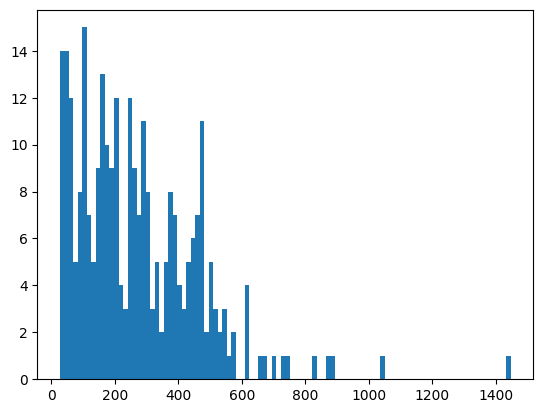

In [15]:
import matplotlib.pyplot as plt
response = supabase.table("document").select("*").execute()
data = response.data

print(len(data))
lenght = []
for item in data:
    lenght.append(len(item["raw_doc"].split())) 
plt.hist(lenght, bins=100)

In [16]:
import asyncio
import json
from openai import OpenAI, AsyncOpenAI
from typing import List, Dict

async def invoke_async(request):    
    client = AsyncOpenAI()
    completion = await client.chat.completions.create(
        model="gpt-4o-mini",
        temperature=0,
        messages=[
            {"role": "system", "content": "Bạn là một chuyên gia tư vấn thông tin và quy chế về Trường Đại học Bách Khoa Hà Nội"},
            {
                "role": "user",
                "content": request
            }
        ]
    )

    return completion.choices[0].message.content

def create_request(raw_data: str, n_questions: int = 3) -> str:
    prompt = f"""
Dựa vào thông tin sau, hãy tạo {n_questions} câu hỏi và câu trả lời liên quan:
{raw_data}

=== Yêu cầu ===
Đặt câu hỏi cụ thể (câu hỏi về đối tượng trong thông tin) thay vì câu hỏi chung như: Thông tin chính trong đoạn văn đã cho là gì, quy định này là gì, v.v.

Format trả về phải là một list các dict với format:
[
    {{"question": "câu hỏi 1", "answer": "câu trả lời 1"}},
]
"""

    return prompt

async def process_documents(data: List[Dict], batch_size: int = 5) -> List[Dict]:
    """Process documents in batches using invoke_async"""
    all_results = []
    
    for i in range(0, len(data), batch_size):
        batch = data[i:i + batch_size]
        batch_results = await process_batch(batch)
        all_results.extend(batch_results)
        print(f"Processed batch {i//batch_size + 1}/{(len(data) + batch_size - 1)//batch_size}")
    
    return all_results

async def process_batch(batch: List[Dict]) -> List[Dict]:
    """Process a single batch of documents"""
    tasks = []
    
    for doc in batch:
        if len(doc["raw_doc"].split()) < 200:
            request = create_request(doc['raw_doc'], 1)
        elif len(doc["raw_doc"].split()) < 400:
            request = create_request(doc['raw_doc'], 2)
        elif len(doc["raw_doc"].split()) < 600:
            request = create_request(doc['raw_doc'], 3)
        elif len(doc["raw_doc"].split()) < 800:
            request = create_request(doc['raw_doc'], 4)
        else:
            request = create_request(doc['raw_doc'], 5)
        tasks.append(invoke_async(request))
    
    results = await asyncio.gather(*tasks, return_exceptions=True)
    
    processed_data = []
    for doc, result in zip(batch, results):
        if isinstance(result, Exception):
            print(f"Error processing doc {doc['id']}: {str(result)}")
            continue
            
        try:
            # Parse the GPT response into questions and answers
            if "```" in result:
                result = result.replace("```", "").replace("json", "").strip()
            qa_list = json.loads(result)
            for qa in qa_list:
                processed_data.append({
                    "question": qa["question"],
                    "answer": qa["answer"],
                    "raw_data": doc["raw_doc"],
                    "id": doc["id"]
                })
        except Exception as e:
            print(f"Error parsing result for doc {doc['id']}: {str(e)}")
            continue
    
    return processed_data
    

In [17]:
results = await process_documents(data, batch_size=10)
with open('question_generate.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

Processed batch 1/29
Processed batch 2/29
Processed batch 3/29
Processed batch 4/29
Processed batch 5/29
Processed batch 6/29
Processed batch 7/29
Processed batch 8/29
Processed batch 9/29
Processed batch 10/29
Processed batch 11/29
Processed batch 12/29
Processed batch 13/29
Processed batch 14/29
Processed batch 15/29
Processed batch 16/29
Processed batch 17/29
Processed batch 18/29
Processed batch 19/29
Processed batch 20/29
Processed batch 21/29
Processed batch 22/29
Processed batch 23/29
Processed batch 24/29
Processed batch 25/29
Processed batch 26/29
Processed batch 27/29
Processed batch 28/29
Processed batch 29/29


In [28]:
with open('question_generate.json', 'r', encoding='utf-8') as f:
    results = json.load(f)
rag_question = [{"question": result['question'], "vector": None} for result in results]
print (rag_question)
response = supabase.table("rag_question").insert(rag_question).execute()

[{'question': 'Ngành đào tạo là gì và ai quản lý mã số của nó?', 'vector': None}, {'question': 'Chương trình đào tạo tích hợp cử nhân-kỹ sư có thời gian thiết kế và khối lượng học tập như thế nào?', 'vector': None}, {'question': 'Chương trình ELITECH có những đặc điểm gì nổi bật?', 'vector': None}, {'question': 'Thời gian và khối lượng tín chỉ tối thiểu cho chương trình đào tạo cử nhân tại Trường Đại học Bách Khoa Hà Nội là bao nhiêu?', 'vector': None}, {'question': 'Chương trình đào tạo thạc sĩ theo hình thức tích hợp có thời gian và khối lượng tín chỉ tối thiểu là bao nhiêu?', 'vector': None}, {'question': 'Sinh viên tốt nghiệp cử nhân có thể tích lũy bao nhiêu tín chỉ của chương trình thạc sĩ trong chương trình đào tạo cử nhân-thạc sĩ tích hợp?', 'vector': None}, {'question': 'Sinh viên có thể tốt nghiệp sớm hơn thời gian quy định không? Nếu có, điều kiện nào cần đáp ứng?', 'vector': None}, {'question': 'Thời gian tối đa cho sinh viên học liên thông được phép chậm tiến độ là bao nhi

In [33]:
chitchatSample = [
    "Thời tiết hôm nay như thế nào?",
    "Ngoài trời nóng bao nhiêu?",
    "Ngày mai có mưa không?",
    "Nhiệt độ hiện tại là bao nhiêu?",
    "Bạn có thể cho tôi biết điều kiện thời tiết hiện tại không?",
    "Cuối tuần này có nắng không?",
    "Nhiệt độ hôm qua là bao nhiêu?",
    "Đêm nay trời sẽ lạnh đến mức nào?",
    "Ai là tổng thống đầu tiên của Hoa Kỳ?",
    "Chiến tranh thế giới thứ hai kết thúc vào năm nào?",
    "Bạn có thể kể cho tôi về lịch sử của internet không?",
    "Tháp Eiffel được xây dựng vào năm nào?",
    "Ai đã phát minh ra điện thoại?",
    "Tên của bạn là gì?",
    "Bạn có tên không?",
    "Tôi nên gọi bạn là gì?",
    "Ai đã tạo ra bạn?",
    "Bạn bao nhiêu tuổi?",
    "Bạn có thể kể cho tôi một sự thật thú vị không?",
    "Bạn có biết bất kỳ câu đố thú vị nào không?",
    "Màu sắc yêu thích của bạn là gì?",
    "Bộ phim yêu thích của bạn là gì?",
    "Bạn có sở thích nào không?",
    "Ý nghĩa của cuộc sống là gì?",
    "Bạn có thể kể cho tôi một câu chuyện cười không?",
    "Thủ đô của Pháp là gì?",
    "Dân số thế giới là bao nhiêu?",
    "Có bao nhiêu châu lục?",
    "Ai đã viết 'Giết con chim nhại'?",
    "Bạn có thể cho tôi một câu nói của Albert Einstein không?"
]
chitchat_question = [{"question": question, "vector": None} for question in chitchatSample]
supabase.table("chitchat_question").insert(chitchat_question).execute()

APIResponse[~_ReturnT](data=[{'id': 1, 'question': 'Thời tiết hôm nay như thế nào?', 'vector': None}, {'id': 2, 'question': 'Ngoài trời nóng bao nhiêu?', 'vector': None}, {'id': 3, 'question': 'Ngày mai có mưa không?', 'vector': None}, {'id': 4, 'question': 'Nhiệt độ hiện tại là bao nhiêu?', 'vector': None}, {'id': 5, 'question': 'Bạn có thể cho tôi biết điều kiện thời tiết hiện tại không?', 'vector': None}, {'id': 6, 'question': 'Cuối tuần này có nắng không?', 'vector': None}, {'id': 7, 'question': 'Nhiệt độ hôm qua là bao nhiêu?', 'vector': None}, {'id': 8, 'question': 'Đêm nay trời sẽ lạnh đến mức nào?', 'vector': None}, {'id': 9, 'question': 'Ai là tổng thống đầu tiên của Hoa Kỳ?', 'vector': None}, {'id': 10, 'question': 'Chiến tranh thế giới thứ hai kết thúc vào năm nào?', 'vector': None}, {'id': 11, 'question': 'Bạn có thể kể cho tôi về lịch sử của internet không?', 'vector': None}, {'id': 12, 'question': 'Tháp Eiffel được xây dựng vào năm nào?', 'vector': None}, {'id': 13, 'ques